In [115]:
# Bước 1: Import và load dữ liệu
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Định nghĩa features và target trước khi load dữ liệu
features = ['Market Cap (B)', 'Enterprise Value (B)', 'Price/Sales', 'Price/Book']  # Điều chỉnh tên theo file CSV
target = 'Forward P/E'

def convert_number(value):
    if isinstance(value, str):
        value = value.replace(',', '').strip()
        
        if value == '--':
            return np.nan
            
        multiplier = {
            'T': 1e12,
            'B': 1e9,
            'M': 1e6
        }
        
        for unit, mult in multiplier.items():
            if value.endswith(unit):
                try:
                    return float(value[:-1]) * mult
                except ValueError:
                    return np.nan
                
        try:
            return float(value)
        except ValueError:
            return np.nan
    return value

def load_data(data_path):
    csv_files = glob.glob(data_path)
    dataframes = []
    for file in csv_files:
        try:
            # Đọc file với index_col=0 để tránh nhầm lẫn với tên chỉ số
            df = pd.read_csv(file, index_col=0)
            symbol = os.path.basename(file).split('_')[-1].split('.')[0]
            df['Symbol'] = symbol
            
            # Chuyển đổi các giá trị số
            numeric_cols = df.columns[:-1]  # Trừ cột Symbol
            for col in numeric_cols:
                df[col] = df[col].apply(convert_number)
                
            dataframes.append(df)
            print(f"Successfully loaded {file}")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    return pd.concat(dataframes, ignore_index=True)

# Sử dụng hàm load_data
try:
    data = load_data('../Data/*.csv')
    print("\nData shape:", data.shape)
    print("\nFirst few rows:")
    print(data.head())
    print("\nMissing values:")
    print(data.isnull().sum())
except Exception as e:
    print(f"Error processing data: {e}")

Successfully loaded ../Data\detail_data_AMD.csv
Successfully loaded ../Data\detail_data_AMZN.csv
Successfully loaded ../Data\detail_data_ASTS.csv
Successfully loaded ../Data\detail_data_BTCWF.csv
Successfully loaded ../Data\detail_data_CNH.csv
Successfully loaded ../Data\detail_data_COIN.csv
Successfully loaded ../Data\detail_data_CSCO.csv
Successfully loaded ../Data\detail_data_DIS.csv
Successfully loaded ../Data\detail_data_ELAB.csv
Successfully loaded ../Data\detail_data_IONQ.csv
Successfully loaded ../Data\detail_data_LUNR.csv
Successfully loaded ../Data\detail_data_MVST.csv
Successfully loaded ../Data\detail_data_NU.csv
Successfully loaded ../Data\detail_data_PAY.csv
Successfully loaded ../Data\detail_data_PLTR.csv
Successfully loaded ../Data\detail_data_QBTS.csv
Successfully loaded ../Data\detail_data_QUBT.csv
Successfully loaded ../Data\detail_data_RGTI.csv
Successfully loaded ../Data\detail_data_SMCI.csv
Successfully loaded ../Data\detail_data_SMR.csv
Successfully loaded ../Dat

In [116]:
# Xác định features và target
features = ['9/30/2024', '6/30/2024', '3/31/2024', '12/31/2023', '9/30/2023']
target = 'Current'

# Kiểm tra xem các cột có tồn tại trong data không
print("Available columns:", data.columns.tolist())

Available columns: ['Current', '9/30/2024', '6/30/2024', '3/31/2024', '12/31/2023', '9/30/2023', 'Symbol', '6/30/2023', '3/31/2023', '7/31/2024', '4/30/2024', '1/31/2024', '10/31/2023', '7/31/2023']


In [117]:
# Chỉ import các thư viện mới cần thiết cho học sâu
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

2.18.0


In [118]:
data_clean = data.copy()
data_clean = data_clean.dropna(subset=features + [target])

def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]
    return df

data_clean = remove_outliers(data_clean, features + [target])

print("Shape after cleaning:", data_clean.shape)
print("\nMissing values after cleaning:")
print(data_clean.isnull().sum())

X = data_clean[features].values
y = data_clean[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Shape after cleaning: (24, 14)

Missing values after cleaning:
Current        0
9/30/2024      0
6/30/2024      0
3/31/2024      0
12/31/2023     0
9/30/2023      0
Symbol         0
6/30/2023     24
3/31/2023     24
7/31/2024     24
4/30/2024     24
1/31/2024     24
10/31/2023    24
7/31/2023     24
dtype: int64


In [119]:
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(len(features),)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'), 
    Dense(1)
])

# Biên dịch mô hình
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='huber',  # Robust loss function
    metrics=['mae']
)


In [120]:
# Huấn luyện mô hình
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 11.7544 - mae: 12.2534 - val_loss: 5.6710 - val_mae: 6.1710
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 11.6953 - mae: 12.1930 - val_loss: 5.6028 - val_mae: 6.1028
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 11.6378 - mae: 12.1338 - val_loss: 5.5344 - val_mae: 6.0344
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 11.5859 - mae: 12.0798 - val_loss: 5.4669 - val_mae: 5.9669
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 11.5363 - mae: 12.0277 - val_loss: 5.4032 - val_mae: 5.9032
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 11.4880 - mae: 11.9766 - val_loss: 5.3418 - val_mae: 5.8418
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 11.4448 - mae: 11.9301 - val_loss: 5.2800 - val_mae: 5.7800
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 11.4053 - mae: 11.8869 - val_loss: 5.2189 - val_mae: 5.7189
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 

In [121]:
# Đánh giá mô hình trên tập test
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'\nMean Squared Error (MSE): {loss}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 6.6425371170043945
Mean Absolute Error (MAE): 7.1425371170043945


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
R2 Score: -0.13949905598817347


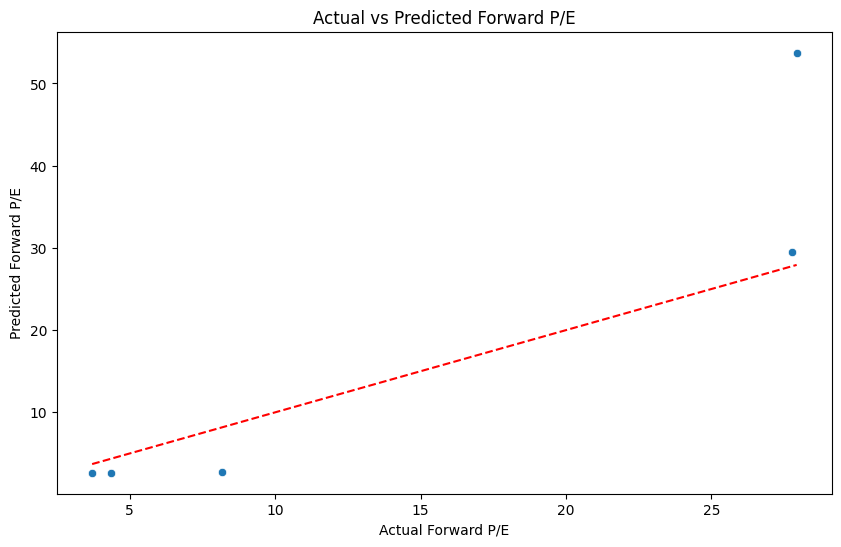

In [122]:
# Dự đoán trên tập test
y_pred = model.predict(X_test_scaled).flatten()

# Tính R2 Score
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
print(f'R2 Score: {r2}')

# Trực quan hóa kết quả
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Forward P/E')
plt.ylabel('Predicted Forward P/E')
plt.title('Actual vs Predicted Forward P/E')
plt.show()

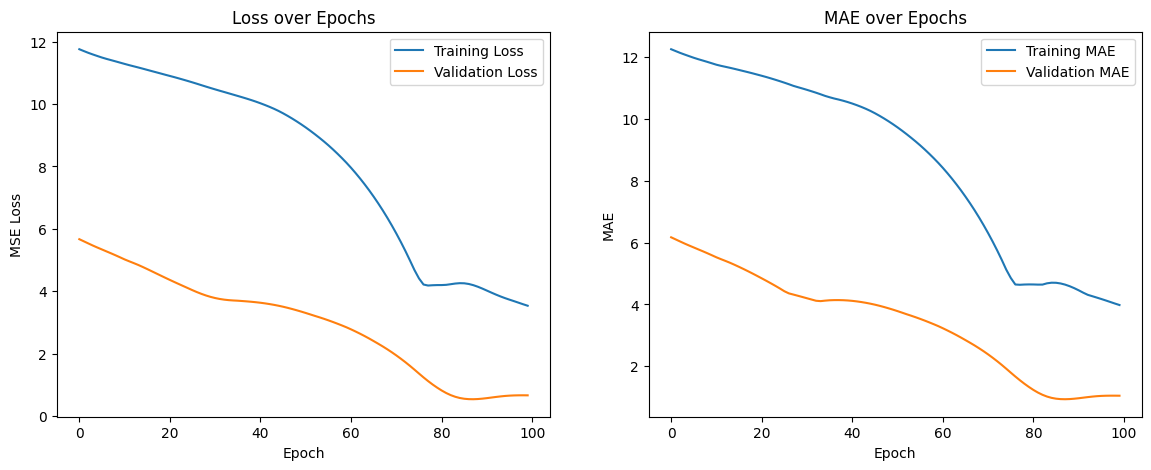

In [123]:
# Plot Loss và MAE qua các epoch
plt.figure(figsize=(14,5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [132]:
# Bước 1: Kiểm tra dữ liệu sau khi làm sạch
def check_available_symbols(data_clean, features, target):
    available_symbols = []
    for symbol in data_clean['Symbol'].unique():
        example_data = data_clean[data_clean['Symbol'] == symbol]
        if not example_data[features + [target]].isnull().values.any():
            available_symbols.append(symbol)
    return available_symbols

# In ra các symbol có thể dự đoán
available_symbols = check_available_symbols(data_clean, features, 'Current')
print("Symbols available for prediction:")
print(available_symbols)

# Bước 2: Sửa lại hàm dự đoán
def predict_price_sales(symbol, data_clean, scaler, model, features):
    # Lấy dữ liệu của mã cổ phiếu
    example_data = data_clean[data_clean['Symbol'] == symbol]
    
    if example_data.empty:
        print(f"No data available for symbol {symbol}")
        return None
        
    example_data = example_data.iloc[0]
    
    # In thông tin chi tiết hơn về dữ liệu
    print("\nInput data:")
    print(f"Symbol: {symbol}")
    print("\nAll available metrics:")
    for col in example_data.index:
        print(f"{col}: {example_data[col]}")
    
    print("\nFeatures being used:")
    for feature in features:
        print(f"{feature}: {example_data[feature]:.2e}")
    
    # Dự đoán Price/Sales
    input_data = example_data[features].values.reshape(1, -1)
    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)[0][0]
    
    # In kết quả với thông tin rõ ràng hơn
    print(f'\nPredicted Price/Sales: {prediction:.2f}')
    print(f'Actual Price/Sales (Current): {example_data["Current"]:.2f}')
    print(f'Error: {abs(prediction - example_data["Current"]):.2f}')
    
    return prediction

# Test với symbol có sẵn
if available_symbols:
    symbol = available_symbols[2]  # Lấy symbol đầu tiên trong danh sách có thể dự đoán
    result = predict_price_sales(symbol, data_clean, scaler, model, features)
else:
    print("No symbols available for prediction.")

Symbols available for prediction:
['AMD', 'AMZN', 'COIN', 'IONQ', 'PLTR', 'QUBT', 'TXRH']

Input data:
Symbol: COIN

All available metrics:
Current: 15.34
9/30/2024: 10.33
6/30/2024: 14.74
3/31/2024: 21.7
12/31/2023: 14.53
9/30/2023: 6.37
Symbol: COIN
6/30/2023: nan
3/31/2023: nan
7/31/2024: nan
4/30/2024: nan
1/31/2024: nan
10/31/2023: nan
7/31/2023: nan

Features being used:
9/30/2024: 1.03e+01
6/30/2024: 1.47e+01
3/31/2024: 2.17e+01
12/31/2023: 1.45e+01
9/30/2023: 6.37e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Predicted Price/Sales: 13.02
Actual Price/Sales (Current): 15.34
Error: 2.32


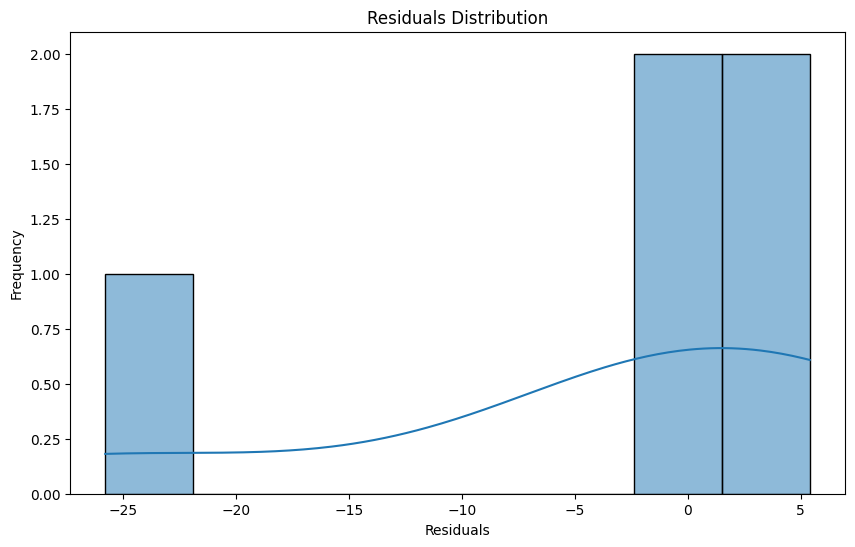

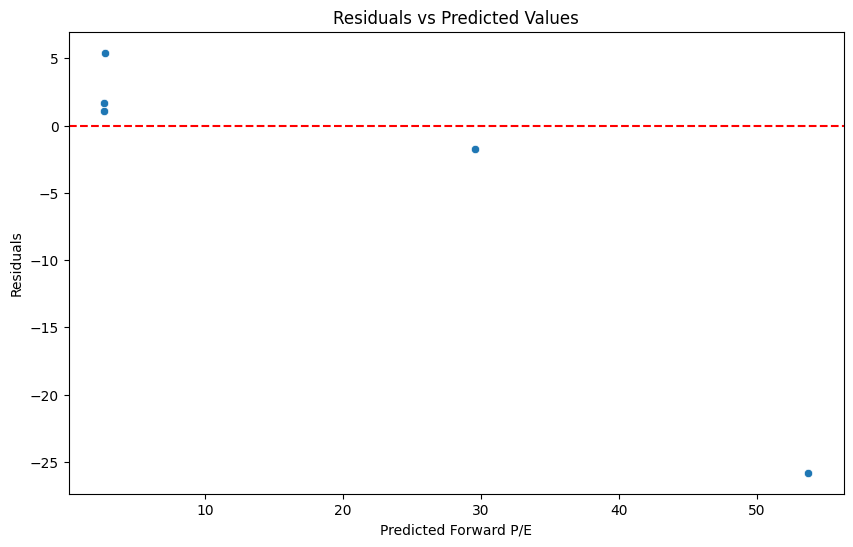

In [133]:
# Phân tích residuals
residuals = y_test - y_pred

# Histogram của residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot residuals vs predicted values
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Forward P/E')
plt.ylabel('Residuals')
plt.show()